# Voortoets, Module 3 - Inhoudelijke uitwerking van module 3 in de online toepassing van de voortoets: het bepalen van de reikwijdte van effecten voor de indirecte effectgroepen - Thema Grondwater

Auteurs:
J. Bronders, J. Patyn, I.Van Keer, N. Desmet, J. Vos, W. Peelaerts, L. Decorte & A. Gobin

In opdracht van ANB, 2013

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from etc import newfig
from scipy.special import k0 as K0, k1 as K1, erfc, exp1
from scipy.signal import lfilter
from itertools import cycle

import wellfunctionalities as wf

from importlib import reload

In [4]:
class Dirs:
    """Namespace for directories in project"""
    def __init__(self):
        self.home = '/Users/Theo/Entiteiten/Hygea/2022-AGT/jupyter/'
        self.data = os.path.join(self.home, 'data')
        self.images = os.path.join(self.home, 'images')
    
dirs = Dirs()
assert os.path.isdir(dirs.data), f"{dirs.data} not found!"
assert os.path.isdir(dirs.images), f"{dirs.images} not found!"

# Test wf.Mirrors

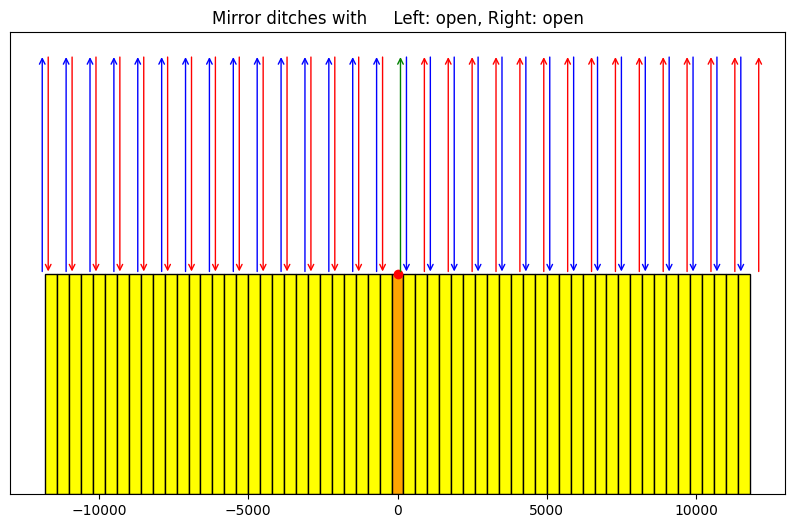

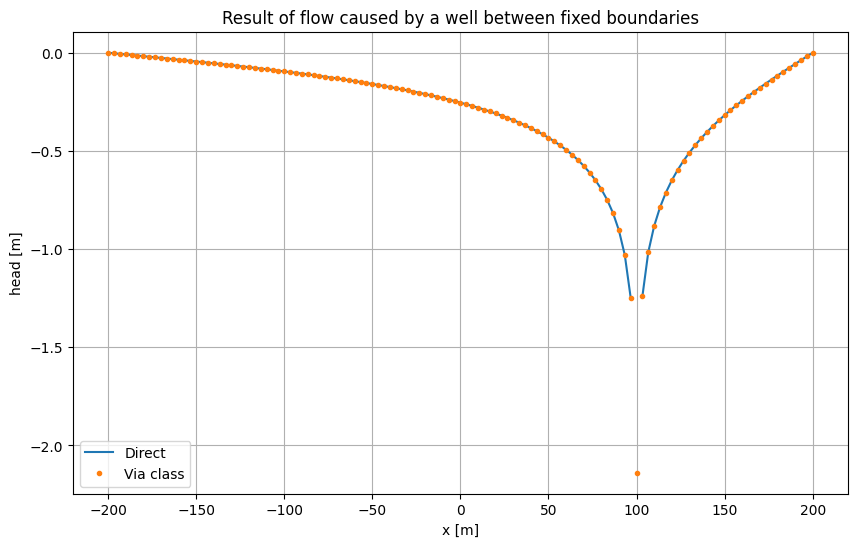

In [767]:

# Example, immediately shows all possibilities
kD, S, c= 600, 0.001, 200
lambda_ = np.sqrt(kD * c)

xL, xR, xw, N= -200, 200, 100, 30

# =============================================================
fig, ax = plt.subplots(figsize=(10, 6))
md = wf.Mirrors(xL, xR, xw=xw, N=N, Lclosed=False, Rclosed=False)
_ = md.show(ax=ax, figsize=(8, 2), fcs=('yellow', 'orange'))
fig.savefig(os.path.join(dirs.images, "put_spiegelschema.png"))
# =============================================================
Q = -1200.
n = 0
L = xR - xL
x = np.linspace(xL - n * L, xR + n * L, 121)

# Regular
s = np.zeros_like(x)
r = np.sqrt((md.xw - x) ** 2)
s = md.sw * Q / (2 * np.pi * kD) * K0( r / lambda_)
for xw, sgn in zip(md.xLD, md.sLD):
    r = np.sqrt((xw - x) ** 2)
    s += sgn * Q / (2 * np.pi * kD) * K0(r / lambda_)
for xw, sgn in zip(md.xRD, md.sRD):
    r = np.sqrt((xw - x) ** 2)
    s += sgn * Q / (2 * np.pi * kD) * K0(r / lambda_)
s1 = s
    
# Met deGlee class
dGlee = wf.wDeGlee(xw=md.xw, yw=0., aqprops={'kD': kD, 'lambda': lambda_})

s = np.zeros_like(x)

s = dGlee.dd(x=x, Q=Q)
for xw, sgn in zip(md.xLD, md.sLD):
    dGlee.xw = xw
    s += dGlee.dd(x=x, Q= sgn * Q)
for xw, sgn in zip(md.xRD, md.sRD):
    dGlee.xw = xw
    s += dGlee.dd(x=x, Q= sgn * Q)
s2 = s
 
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Result of flow caused by a well between fixed boundaries")
ax.set(xlabel="x [m]", ylabel='head [m]')
ax.plot(x, s1, label="Direct")
ax.plot(x, s2, '.', label="Via class")
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "put_in_strip_spiegelen.png"))
plt.show()

# Use Mirrors to compute the drainage of a groundwater basin.

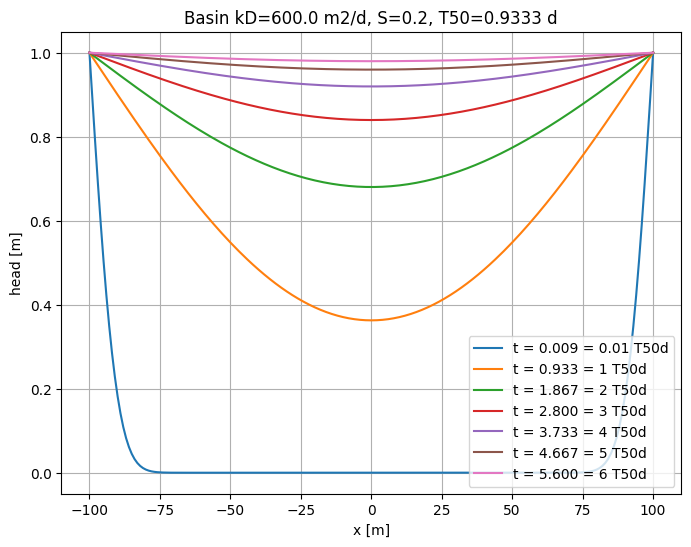

In [758]:
kD, S = 600., 0.2
xL, xR, AL, AR = -100., 100., 1.0, 1.0
b = (xR - xL) / 2
T50 = 0.28 * b ** 2 * S / kD

ts = np.arange(7) * T50
ts[0] = 0.01 * T50
x = np.linspace(xL, xR, 201)

md = wf.Mirrors(xL, xR, N=30, Lclosed=False, Rclosed=False)
_, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f"Basin kD={kD} m2/d, S={S}, T50={T50:.4g} d")
ax.set(xlabel="x [m]", ylabel="head [m]")
for t in ts:
    s = np.zeros_like(x)
    xM = 0.5 * (xL + xR)
    for xD, sgn in zip(md.xLD, md.sLD):
        x_ = xD - x if xD >= xM else x - xD
        u = x_ * np.sqrt(S / (4 *  kD * t))
        s += sgn * AL * erfc(u)
    for xD, sgn in zip(md.xRD, md.sRD):
        x_ = xD - x if xD >= xM else x - xD
        u = x_ * np.sqrt(S / (4 *  kD * t))
        s += sgn * AR * erfc(u)
    ax.plot(x, s, label=f"t = {t:.3f} = {t/T50:.4g} T50d")
ax.grid()
ax.legend(loc="lower right")
fig.savefig(os.path.join(dirs.images, "bassin_drainage_spiegel_sloten.png"))
plt.show()

    

# Put in een strip met harde randen (spiegelen)

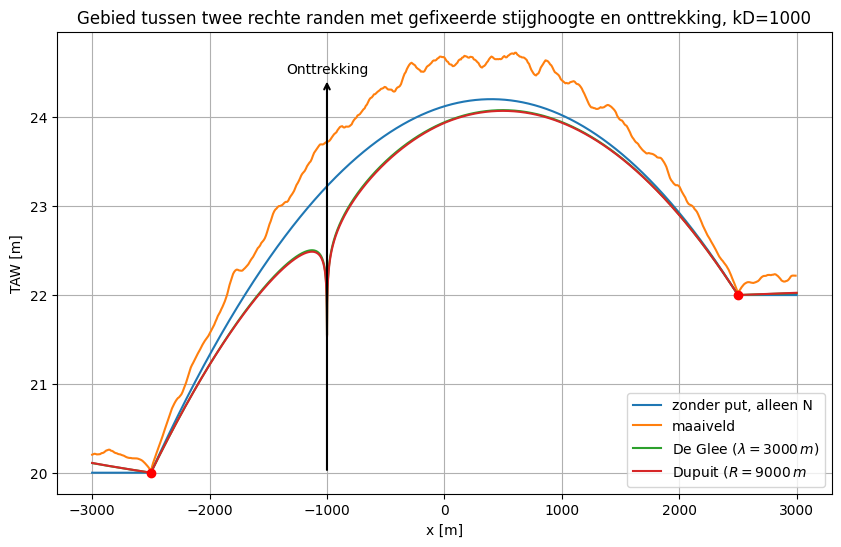

In [ ]:
# reload(wf)

N, kD = 0.001, 20 * 50
lamb_L, lamb_R = 200., 300.
aqprops = {'kD': kD, 'lambda_L': lamb_L, 'lambda_R': lamb_R}

xL, xR, hL, hR = -2500., 2500., 20., 22.
boundaries={'xL': xL, 'xR': xR, 'hL': hL, 'hR': hR}

Q = -1200 # m3/d

x = np.linspace(xL - 500., xR + 500., 6000)
y = np.zeros_like(x)

xW, yW = xM - 1000., 0.

L = xR - xL
sect1 = wf.Section(boundaries=boundaries, aqprops={'kD': kD, 'lambda_L': 0., 'lambda_R': 0.})
sect2 = wf.Section(boundaries=boundaries, aqprops={'kD': kD, 'lambda_L': 0., 'lambda_R': 0.})
h1 = sect1.h(x=x, N=N)
h2 = sect2.h(x=x, N=N)

title=f"Gebied tussen twee rechte randen met gefixeerde stijghoogte en onttrekking, kD={kD}"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="TAW [m]")
ax.grid()

ax.plot(x, h1, label="zonder put, alleen N")
ax.plot(x[::10], wf.ground_surface(x[::10], xL=xL, xR=xR, yM=1, Lfilt=8) + h1[::10], label='maaiveld')

# Get the well positions
md = wf.Mirrors(xL=xL, xR=xR, xw=xW, N=5)
# md.show()

yld = yrd = 0.

# The real (actual well:
lambda_ = 3000.
R = lambda_ * 3
wGlee   = wf.wDeGlee(xw=md.xw, yw=yW, aqprops={'kD': kD, 'lambda': lambda_})
wDupuit = wf.wDupuit(xw=md.xw, yw=yW, aqprops={'kD': kD})


# We can also use leaky aquifer which ensures the drawdown approaches zero at infinity
sG = wGlee.dd(  x=x, Q=Q)
sD = wDupuit.dd(x=x, Q=Q, R=R)
# Add the effect of all the mirror wells
for i, (xld, sld, xrd, srd) in enumerate(zip(md.xLD, md.sLD, md.xRD, md.sLD)):
    wGlee.xw   = xld
    wDupuit.xw = xld
    sG += wGlee.dd(  x=x, Q= sld * Q)
    sD += wDupuit.dd(x=x, Q= sld * Q, R=R)
    wGlee.xw   = xrd
    wDupuit.xw = xrd
    sG += wGlee.dd(  x=x, Q= srd * Q)
    sD += wDupuit.dd(x=x, Q= srd * Q, R=R)
    
ax.plot(x, h1 + sG, label=fr"De Glee ($\lambda = {lambda_:.0f}\, m$)")
ax.plot(x, h1 + sD, label=fr"Dupuit ($R={R:.0f}\, m$")
ax.annotate('Onttrekking', xy=(md.xw, 20), xytext=(md.xw, 24.5), ha='center', arrowprops={'arrowstyle': '<-', 'lw': 1.5} )
ax.legend(loc="lower right")
ax.plot([xL, xR], [hL, hR], 'ro', label='Vaste stijghoogtes')

fig.savefig(os.path.join(dirs.images, "puntbron_hantush_strip_A.png"), transparent=True)
plt.show()


# Spiegelen: Het gaat perfect

De plek van de spielelput in de figuur hieronder komt niet overeen met de plek van de echte put.

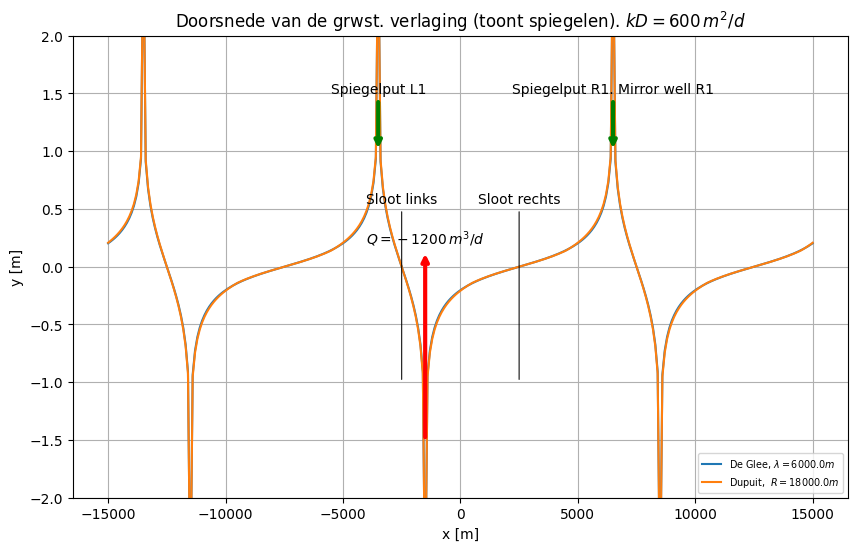

In [782]:
# Grondwaterstanden contourlijnen
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith('0'):
        s = f"{x:.0f}"
    return f"{s}"

x = np.linspace(-15000, 15000, 301)
y = np.linspace(-3000, 3000, 301)
X, Y = np.meshgrid(x, y)

kD, S, xL, xR, xw, yw = 600., 0.2, -2500, 2500., -1500., 0.

md = wf.Mirrors(xL=xL, xR=xR, xw=xw, N=100)

lambda_ = 6000. # Fixtieve zeer hoge spreidingslengte
R = 3 * lambda_

Q = -1200 # m3/d

# Using K0 to make sure dd goes to zero for very large r
# With log, we don't get zero drawdown along both canals, only near y=0

dGlee = wf.wDeGlee( xw=xw, yw=yw, aqprops={'kD': kD, 'lambda': lambda_})
dupuit = wf.wDupuit(xw=xw, yw=yw, aqprops={'kD': kD})

sG = dGlee.dd( x=X, Q=Q)
sD = dupuit.dd(x=X, Q=Q, R=R)

# Add the effect of all the mirror wells
for xl, sl, xr, sr in zip(md.xLD, md.sLD, md.xRD, md.sLD):
    dGlee.xw  = xl
    dupuit.xw = xl
    sG += dGlee.dd(x=X, Q=sl * Q)
    sD += dupuit.dd(x=X, Q=sl * Q, R=R)
    
    dGlee.xw  = xr
    dupuit.xw = xr
    sG += dGlee.dd( x=X, Q=sr * Q)    
    sD += dupuit.dd(x=X, Q=sr * Q, R=R)
    
# Set levels to contour
levels = hL + np.arange(0, 6., 0.2)


title=fr"Doorsnede van de grwst. verlaging (toont spiegelen). $kD={kD:.0f}\,m^2/d$"

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="y [m]")
ax.plot(X[Y[:, 0]==0][0], sG[Y[:,0]==0][0], label=fr"De Glee, $\lambda={lambda_} m$") 
ax.plot(X[Y[:, 0]==0][0], sD[Y[:,0]==0][0], label=fr"Dupuit,  $R = {R} m$")

ax.annotate('Sloot links', [xL, -1], xytext=[xL, 0.55],
            ha='center', arrowprops={'arrowstyle': '-', 'lw': 0.75, 'color': 'black'})
ax.annotate('Sloot rechts', [xR, -1], xytext=[xR, 0.55],
            ha='center', arrowprops={'arrowstyle': '-', 'lw': 0.75, 'color': 'black'})
ax.annotate(fr"$Q={Q}\,m^3/d$", xy=(md.xw, -1.5), xytext=(md.xw, 0.2),
            ha='center', arrowprops={'arrowstyle': '<-', 'lw': 3, 'color': 'red'})
ax.annotate('Spiegelput L1', xy=(md.xLD[0], 1.0), xytext=(md.xLD[0], 1.5),
            ha='center', arrowprops={'arrowstyle': '->', 'lw': 3, 'color': 'green'})
ax.annotate('Spiegelput R1. Mirror well R1', xy=(md.xRD[0], 1.0), xytext=(md.xRD[0], 1.5),
            ha='center', arrowprops={'arrowstyle': '->', 'lw': 3, 'color': 'green'})

ax.grid()
ax.set_ylim(-2, 2) # Ensure arrows are completely visible.
ax.legend(loc="lower right", fontsize="x-small")
fig.savefig(os.path.join(dirs.images, "section_spiegelen.png"))
plt.show()


# Bruggeman, een gebied gaat over in een ander gebied.

Oplossing 370.01 van Bruggmman (1999) beschrijft de verlaging door een put in een semi-gespannen pakket waarvan de eigenschappen kD en c verspringen op de lijn x=0. Deze oplossing biedt de mogelijk om de invloed te berekenen van een put nabij de grens van een hoog droog naar een lager nat gebied.

Voor $x<0$ geldt $k_2D_1$ en $c_1$ zonder onttrekking, terwijl voor $x>0$ $k_2D_2$ en $c_2$ gelden met onttrekking $Q$ op $x=a$. Op $x=0$ geldt dat de stijghoogte voor $x<0$, $\phi_1$ gelijk is aan die voor $x>0$, $\phi_2$ en dat het specifiek debiet in de $x$-richting  $q_x$ daar continue is.

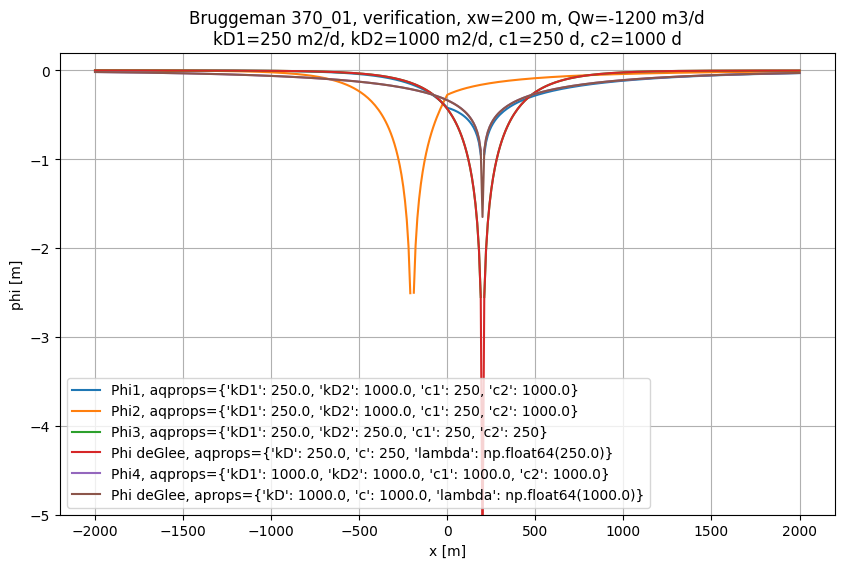

In [762]:
# reload(wf)
kD1, kD2, c1, c2 = 250., 1000., 250, 1000.
L1, L2 = np.sqrt(kD1 * c1), np.sqrt(kD2 * c2)
x = np.linspace(-2000, 2000, 401)
xw = 200.


title = f"Bruggeman 370_01, verification, xw={xw:.4g} m, Qw={Q:.4g} m3/d\nkD1={kD1:.4g} m2/d, kD2={kD2:.4g} m2/d, c1={c1:.4g} d, c2={c2:.4g} d"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="phi [m]")
    
Br1 = wf.Brug370_1(xw=+xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD2, 'c1': c1, 'c2': c2})
Br2 = wf.Brug370_1(xw=-xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD2, 'c1': c1, 'c2': c2})

Br3 = wf.Brug370_1(xw=xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD1, 'c1': c1, 'c2': c1})
dGl1 = wf.wDeGlee( xw=xw, yw=0., aqprops={'kD': kD1, 'c': c1})
Br4 = wf.Brug370_1(xw=xw, yw=0., aqprops={'kD1': kD2, 'kD2': kD2, 'c1': c2, 'c2': c2})
dGl2 = wf.wDeGlee( xw=xw, yw=0., aqprops={'kD': kD2, 'c': c2})

X, Y, Phi1 = Br1.dd(x, Q=Q)    
X, Y, Phi2 = Br2.dd(x, Q=Q)

# Using same kD and c gives just De Glee
X, Y, Phi3 = Br3.dd(x, Q=Q)
PhiG1 = dGl1.dd(x, Q=Q)

# Compare with De Glee
X, Y, Phi4 = Br4.dd(x, Q=Q)
PhiG2 = dGl2.dd(x, Q=Q)

if X.ndim == 1:
    ax.plot(X, Phi1, label=f"Phi1, aqprops={Br1.aq}")
    ax.plot(X, Phi2, label=f"Phi2, aqprops={Br2.aq}")
    ax.plot(X, Phi3, label=f"Phi3, aqprops={Br3.aq}")
    ax.plot(X, PhiG1, label=f"Phi deGlee, aqprops={dGl1.aq}")
    ax.plot(X, Phi4, label=f"Phi4, aqprops={Br4.aq}")
    ax.plot(X, PhiG2, label=f"Phi deGlee, aprops={dGl2.aq}")
else:
    CS = ax.contour(X, Y, Phi1, levels=levels)
    ax.clabel(CS, levels=CS.levels, fmt="{:.2f}")
    
ax.set_ylim(-5, 0.2)
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "brug370_01_test.png"))
plt.show()


# Stijghogte in een hoog gebied dat grenst aan een laag gebied met drainage.

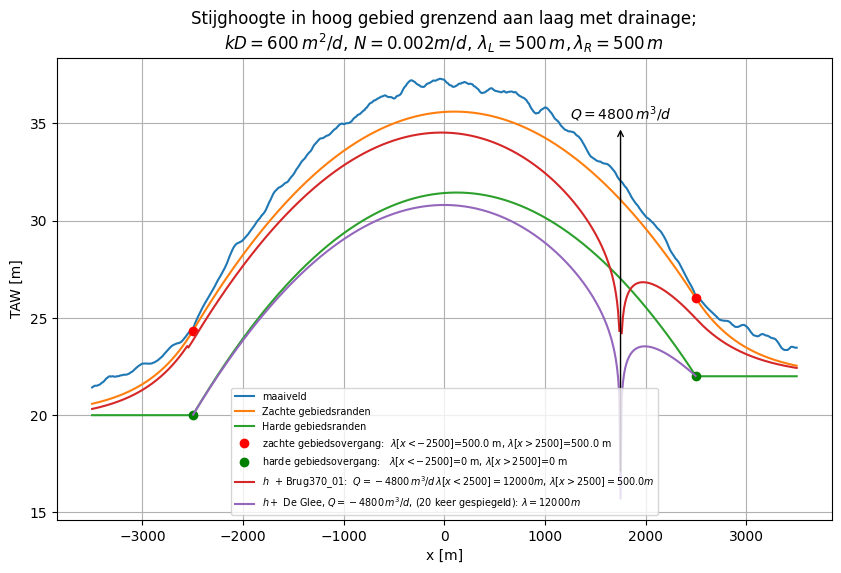

In [15]:
reload(wf)
xL, xR, hL, hR = -2500, 2500, 20., 22.
boundaries ={'xL': xL, 'xR': xR, 'hL': hL, 'hR': hR}
xM = (xL + xR) / 2
xW, yW = xM + 1750., 0.

Q = -4800 # m3/d

N, k, D, lamb_L, lamb_R = 0.002, 30., 20., 500., 500.
lamb_M = 12000 # Middengebied (De Glee)
aqprops1 = {'k': k, 'D': D, 'lambda_L': lamb_L, 'lambda_R': lamb_R}
aqprops2 = {'k': k, 'D': D, 'lambda_L': 0.,     'lambda_R': 0.    }

x = np.linspace(xL -1000., xR + 1000., 601)
y = np.zeros_like(x)

sec1 = wf.Section(boundaries=boundaries, aqprops=aqprops1)
sec2 = wf.Section(boundaries=boundaries, aqprops=aqprops2)

title=fr"""Stijghoogte in hoog gebied grenzend aan laag met drainage;
$kD={aqprops1['kD']:.4g}\, m^2/d,\, N={N:.4g} m/d,\, \lambda_L={aqprops1['lambda_L']:.4g}\, m, \lambda_R={aqprops1['lambda_R']:.4g}\, m$"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="TAW [m]")

ax.plot(x, wf.ground_surface(x, xL=xL, xR=xR, yM=3, Lfilt=8) + sec1.h(x, N=N), label='maaiveld')

ax.plot(x, sec1.h(x=x, N=N), label='Zachte gebiedsranden')
ax.plot(x, sec2.h(x=x, N=N), label='Harde gebiedsranden')

# Plot the boundary locations
hxL = sec1.h(xL, N=N)
hxR = sec1.h(xR, N=N)
ax.plot([xL, xR], [hxL, hxR], 'ro', label=fr"zachte gebiedsovergang:  $\lambda[x<{xL}]$={lamb_L} m, $\lambda[x>{xR}]$={lamb_R} m")

# plot for both lamb_L = 0. and lamb_R = 0.
hxL = sec2.h(xL, N=N)
hxR = sec2.h(xR, N=N)
ax.plot([xL, xR], [hxL, hxR], 'go', label=fr"harde gebiedsovergang:   $\lambda[x<{xL}]$={0} m, $\lambda[x>{xR}]$={0} m")

kD = k * D
cM, c2 = lamb_M ** 2 / kD, lamb_R ** 2  / kD
B2 = wf.Brug370_1(xw=xW - xR, yw=yW, aqprops={'kD1': kD, 'kD2': kD, 'c1': cM, 'c2': c2})
sB = B2.dd(x=x - xR, Q=Q)[-1]
ax.plot(x, sB + sec1.h(x, N=N), label=fr'$h$  + Brug370_01:  $Q={Q:.0f}\,m^3/d\,\lambda[x < {xR}]={lamb_M} m,\,\lambda[x>{xR}]={lamb_R} m$')

# Check de Glee
dGl = wf.wDeGlee(xw=xW, yw=yW, aqprops={'kD': kD, 'lambda': lamb_M})

n = 20
md = wf.Mirrors(xL=xL, xR=xR, xw=xW, N=n, Lclosed=False, Rclosed=False)
sgl = dGl.dd(x=x, Q=Q)
for xl, xr, sl, sr in zip(md.xLD, md.xRD, md.sLD, md.sRD):
    dGl.xw = xl
    sgl += dGl.dd(x=x, Q = sl * Q)
    dGl.xw = xr
    sgl += dGl.dd(x=x, Q = sr * Q)

mask_c = np.logical_and(x >= xL, x <= xR)
ax.plot(x[mask_c], sgl[mask_c] + sec2.h(x[mask_c], N=N), label=fr"$h+$ De Glee, $Q={Q:.0f}\,m^3/d,\,({n}$ keer gespiegeld): $\lambda={lamb_M}\,m$")

ax.annotate(fr'$Q={-Q}\, m^3/d$', xy=(xW, 17), xytext=(xW, 35.2),
            ha='center', arrowprops={'arrowstyle': '<-', 'lw': 1, 'color': 'black'})

ax.grid()
ax.legend(fontsize="x-small", loc="lower center")
fig.savefig(os.path.join(dirs.images, "sectie_zacht_en_hard.png"))
plt.show()


In [807]:
md.xw

1750.0

# Het heeft geen (of nauwelijks) zin om de met de verlaging afnemende pakketdikte mee te nemen in de berekeningen

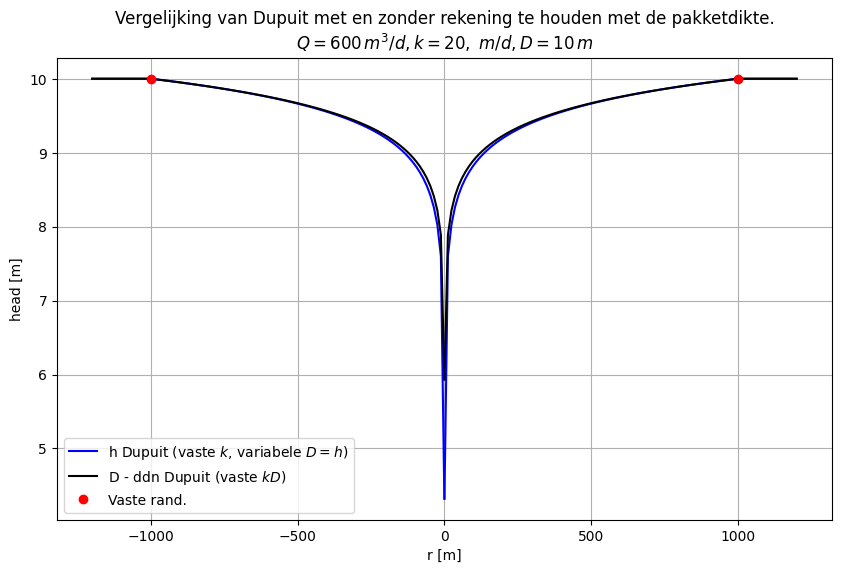

In [755]:
reload(wf)
k, D, R = 20, 10, 1000.
Q = 600
dupuit = wf.wDupuit(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)
r = dupuit.radius(x)
clrs = cycle('bkgmcr')

title = fr"""Vergelijking van Dupuit met en zonder rekening te houden met de pakketdikte.
$Q={Q}\, m^3/d, k={k},\ m/d, D={D}\, m$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

hD = dupuit.h(x=r, Q=Q, R=R)
sD = dupuit.dd(x=r, Q=Q, R=R)

clr = next(clrs)
ax.plot(+r, hD, color=clr, label=r"h Dupuit (vaste $k$, variabele $D=h$)")
ax.plot(-r, hD, color=clr, label="")

clr = next(clrs)
ax.plot(+r, D - sD, color=clr, label=r"D - ddn Dupuit (vaste $kD$)")
ax.plot(-r, D - sD, color=clr, label="")

ddR = dupuit.dd(x=R, Q=Q, R=R)
ax.plot(+R, D - ddR, 'ro', label="Vaste rand.")
ax.plot(-R, D - ddR, 'ro', label="")

ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "dupuit_h_dd_vgl.png"))
plt.show()

# Verruijt. Ook bij Verruijt is het verschil tussen de uitkomsten met vaste of variabele pakketdikte verwaarloosbaar op afstand van de onttrekking.

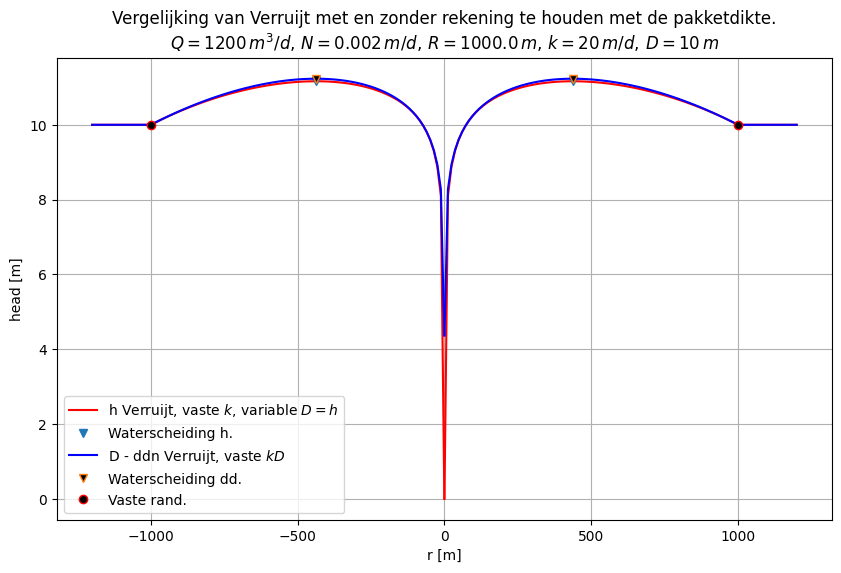

In [754]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 1000.
Q = 1200
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)
r = verruijt.radius(x)

title = fr"""Vergelijking van Verruijt met en zonder rekening te houden met de pakketdikte.
$Q={Q}\,m^3/d,\,N={N}\,m/d,\,R={R}\,m,\,k={k}\,m/d,\,D={D}\,m$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

hV = verruijt.h(x=r, Q=Q, R=R, N=N)
dV = verruijt.dd(x=r, Q=Q, R=R, N=N)

rdiv   = verruijt.rdiv(Q=Q, R=R, N=N)
hdiv   = verruijt.h(rdiv, Q=Q, R=R, N=N)
ddndiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)
ddnR   = verruijt.dd(R, Q=Q, R=R, N=N)

r = verruijt.radius(x)

clrs = cycle('rbgkmc')

clr = next(clrs)
ax.plot(+r, hV, color=clr, label=r"h Verruijt, vaste $k$, variable $D=h$")
ax.plot(-r, hV, color=clr, label="")
ax.plot([-rdiv, rdiv], [hdiv, hdiv], 'v', label="Waterscheiding h.")

clr = next(clrs)
ax.plot(+r, D - dV, color=clr, label=r"D - ddn Verruijt, vaste $kD$")
ax.plot(-r, D - dV, color=clr, label="")
ax.plot([-rdiv, rdiv], [D - ddndiv, D - ddndiv], 'v', mfc='k', label="Waterscheiding dd.")
ax.plot([-R, R], [D - ddnR, D - ddnR], 'ro', mfc='k', label="Vaste rand.")

ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "verruijt_h_dd_vgl.png"))
plt.show()

# Formule van Verruijt voor verschillend grote onttrekkingen

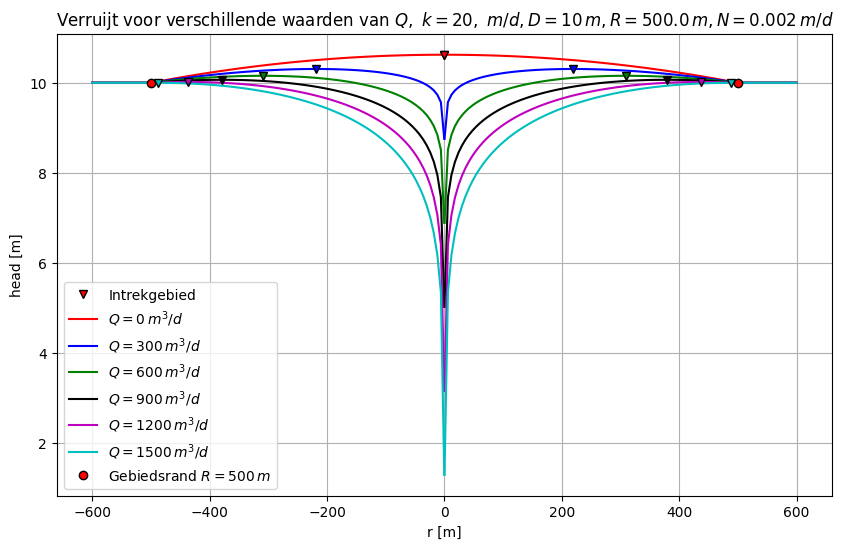

In [797]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 500.
Q0 = 300.
Qs = np.linspace(0., 5., 6) * Q0
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)

title = fr"Verruijt voor verschillende waarden van $Q,\,\, k={k},\ m/d, D={D}\, m, R={R}\, m, N={N}\, m/d$"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

r = verruijt.radius(x)
clrs = cycle('rbgkmc')
for Q in Qs:
    clr = next(clrs)

    rdiv = verruijt.rdiv(Q=Q, R=R, N=N)
    ddiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)

    label="Intrekgebied" if Q==Qs[0] else ""    
    ax.plot(+rdiv, D - ddiv, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rdiv, D - ddiv, 'v', mec='k', mfc=clr, zorder=4)

    dV = verruijt.dd(x=r, Q=Q, R=R, N=N)
    ax.plot(r, D - dV, color=clr, label=fr"$Q={Q:.0f}\, m^3/d$")
    ax.plot(-r, D - dV, color=clr, label="")

ax.plot([-R, R], [D, D], 'ro', mec='k', mfc='r', label=fr"Gebiedsrand $R={R:.0f}\, m$")
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "verruijt_fQ.png"))
plt.show()

# Verruijt voor verschillende groottes van de gebiedsomvang, c.q. de gebiedsradius $R$

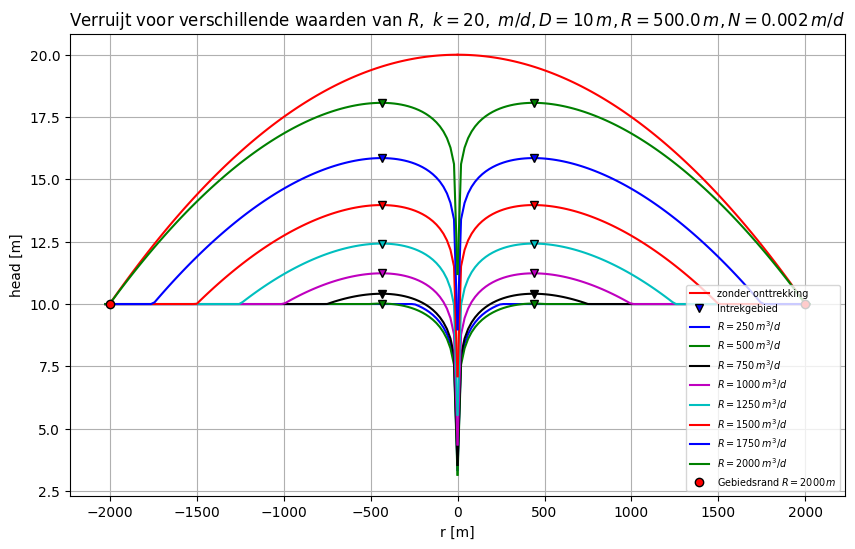

In [752]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 500.
Q = 1200
R0 = 250.
Rs = np.linspace(1., 8., 8) * R0
x = np.linspace(0, 8.1 * R0, 101)

# Put
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})
r = verruijt.radius(x)

title = fr"Verruijt voor verschillende waarden van $R,\,\, k={k},\ m/d, D={D}\, m, R={R}\, m, N={N}\, m/d$"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')
clrs = cycle('rbgkmc')

clr = next(clrs)
ax.plot(+r, D - verruijt.dd(x=r, Q=0, R=Rs[-1], N=N), color=clr, label="zonder onttrekking")
ax.plot(-r, D - verruijt.dd(x=r, Q=0, R=Rs[-1], N=N), color=clr, label="")

for R in Rs:
    clr = next(clrs)

    rdiv = verruijt.rdiv(Q=Q, R=R, N=N)
    ddiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)

    label="Intrekgebied" if R==Rs[0] else ""    
    ax.plot(+rdiv, D - ddiv, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rdiv, D - ddiv, 'v', mec='k', mfc=clr, zorder=4)

    dV = verruijt.dd(x=r, Q=Q, R=R, N=N)
    ax.plot(r, D - dV, color=clr, label=fr"$R={R:.0f}\, m^3/d$")
    ax.plot(-r, D - dV, color=clr, label="")

ax.plot([-R, R], [D, D], 'ro', mec='k', mfc='r', label=fr"Gebiedsrand $R={R:.0f}\, m$")
ax.grid()
ax.legend(loc='lower right', fontsize="x-small")
fig.savefig(os.path.join(dirs.images, "verruijt_fR.png"))
plt.show()

# Verlaging volgens Blom (Verruijt gecombineerd met De Glee)

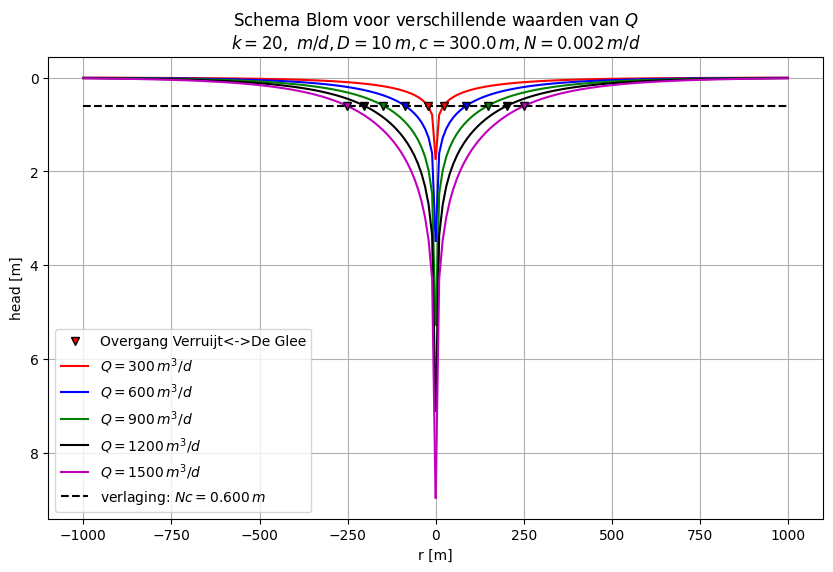

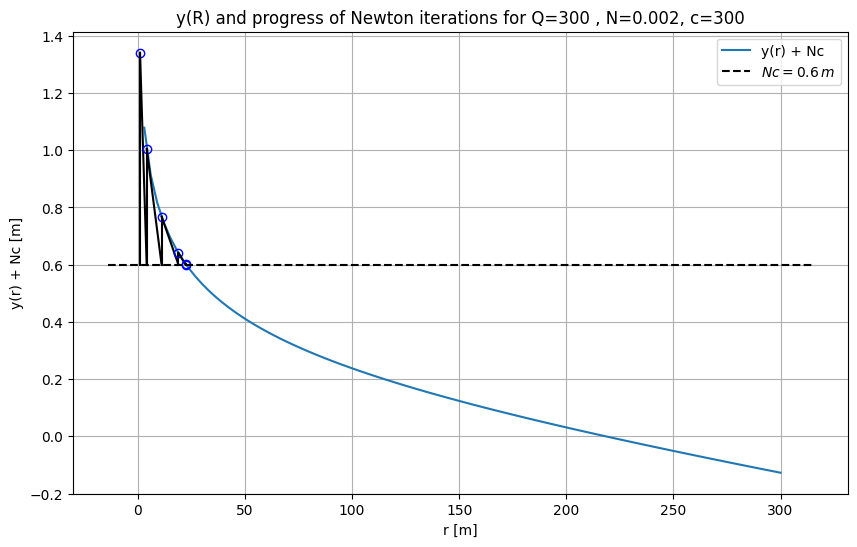

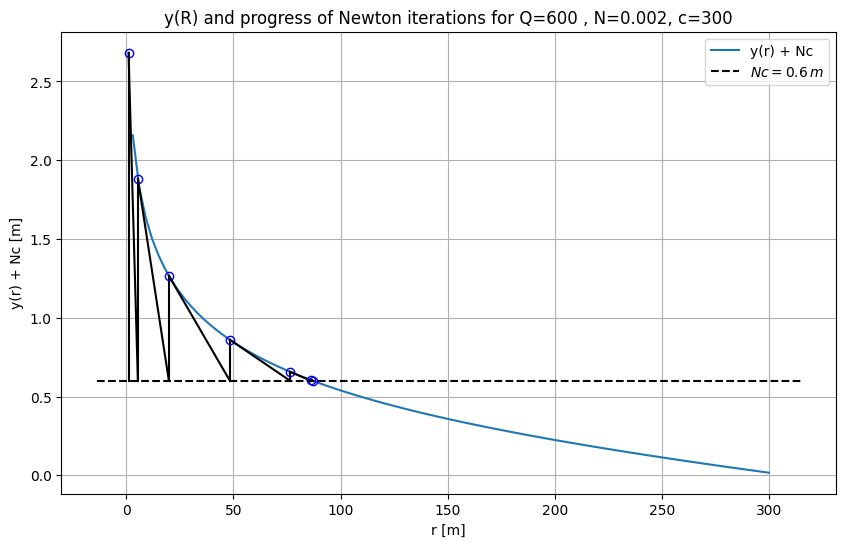

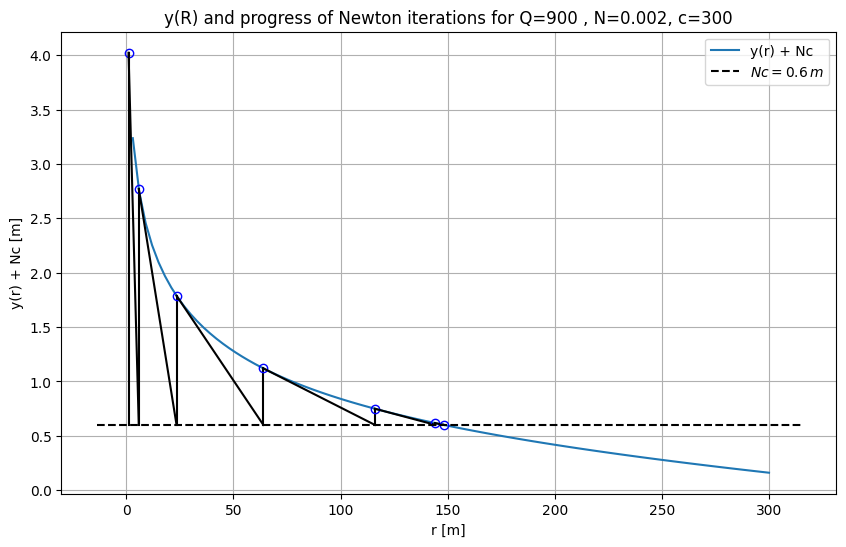

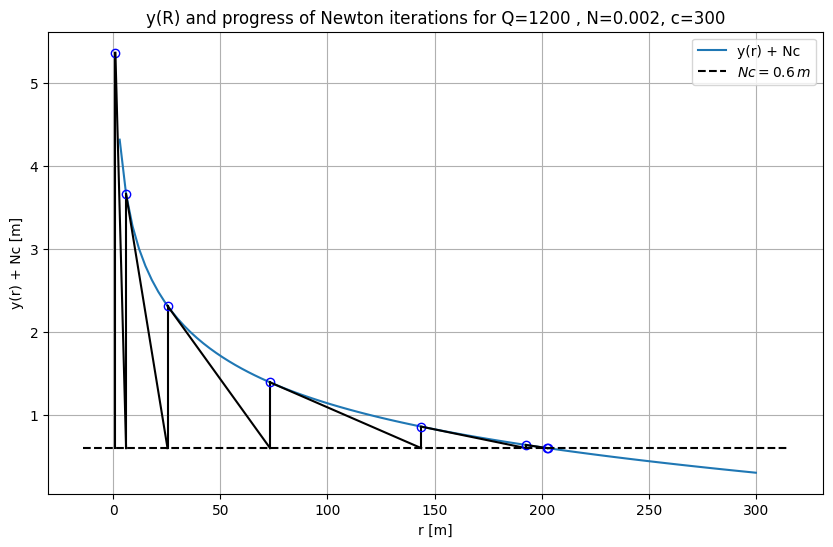

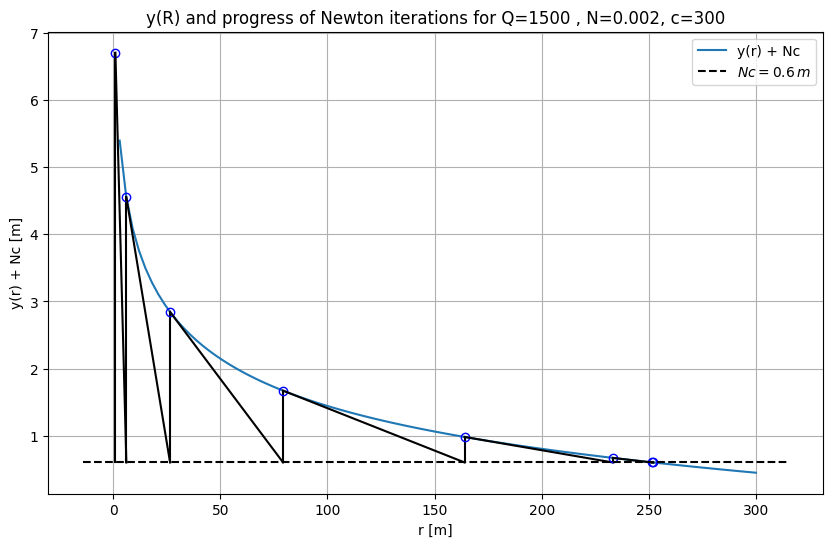

In [19]:
reload(wf)
N, k, D, c= 0.002, 20, 10, 300.
Q0 = 300.
Qs = np.linspace(1., 5., 5) * Q0
aqprops={'k': k, 'D': D, 'c': c}
blom     = wf.wBlom(xw=0, yw=0, aqprops=aqprops)
verruijt = wf.wVerruijt(xw=0., yw=0., aqprops=aqprops)
dGlee    = wf.wDeGlee(xw=0., yw=0., aqprops=aqprops)

lambda_ = blom.aq['lambda']

x = np.linspace(0, 1000, 101)
r = blom.radius(x)

title = fr"""Schema Blom voor verschillende waarden van $Q$
$k={k},\ m/d, D={D}\, m, c={c}\, m, N={N}\, m/d$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

clrs = cycle('rbgkmc')
for Q in Qs:
    blom.plot_newton_progress(R=1.0, Q=Q, N=N, figsize=(10, 6))
    clr = next(clrs)

    rBlom = blom.getR(Q=Q, N=N)
    ddB   = blom.dd(x=rBlom, Q=Q, N=N)

    label="Overgang Verruijt<->De Glee" if Q==Qs[0] else ""    
    ax.plot(+rBlom, ddB, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rBlom, ddB, 'v', mec='k', mfc=clr, zorder=4)

    ddBlom = blom.dd(x=r, Q=Q, N=N)
    ax.plot(+r, ddBlom, color=clr, label=fr"$Q={Q:.0f}\, m^3/d$")
    ax.plot(-r, ddBlom, color=clr, label="")
    
ax.plot([-r[-1], r[-1]], np.array([N*c, N*c]), 'k--', label=fr"verlaging: $Nc={N * c:.3f}\, m$")
ax.invert_yaxis()
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "blom_verl_permanent.png"))
plt.show()

# Verlaging door puntonttrekking tijdsafhankelijk

$$s\approx\frac{Q}{2 \pi kD} \ln\left(\frac R r\right),\,\,\,\mathtt{met}\,\mathtt{invloedsstraal}\,\,\,R=\sqrt{\frac{2.25 kD t}{S}}\,\,\,\mathtt{en}\,\,\,r \le R$$

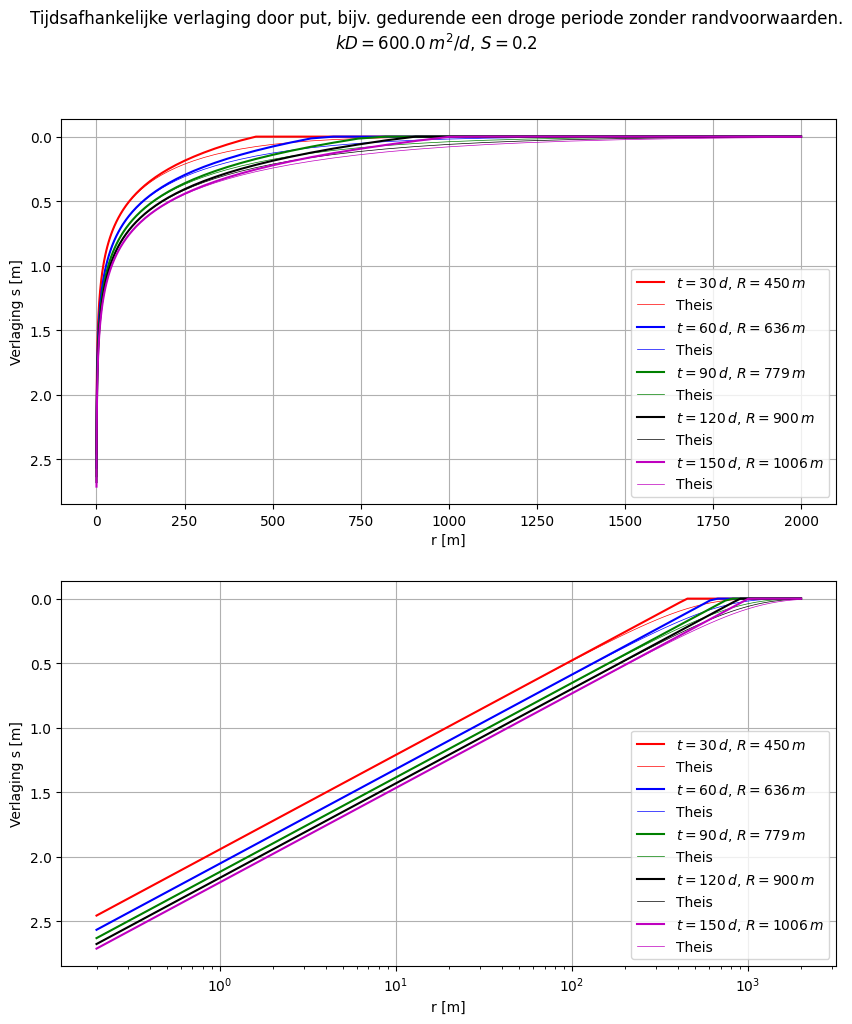

In [790]:
kD, S = 600., 0.2
Q = 1200.
times = np.arange(1, 6) * 30.
x = np.logspace(-1, np.log10(2000.), 101)

dupuit = wf.wDupuit(xw=0., yw=0., aqprops={'kD': kD})
theis  = wf.wTheis(xw=0., yw=0., aqprops={'kD': kD, 'S': S})
r = dupuit.radius(x)

title = fr"""Tijdsafhankelijke verlaging door put, bijv. gedurende een droge periode zonder randvoorwaarden.
$kD={kD}\,m^2/d,\,S={S}$"""

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11))
fig.suptitle(title)


for ax in (ax1, ax2):
    ax.set(xlabel='r [m]', ylabel="Verlaging s [m]")
    if ax == ax2:
        ax.set_xscale('log')
    clrs = cycle("rbgkmc")
    for t in times:
        clr = next(clrs)
        R = np.sqrt(2.25 * kD * t / S)
        ax.plot(r, dupuit.dd(x=r, Q=Q, R=R), clr, label=fr"$t={t:.0f}\,d,\,R={R:.0f}\,m$")
        ax.plot(r, theis.dd(x=r, t=t, Q=Q), clr, lw=0.5, label='Theis')

    ax.invert_yaxis()
    ax.grid()
    ax.legend(loc="lower right")
    
fig.savefig(os.path.join(dirs.images, "put_verl_tijdsafh.png"))
plt.show()

# Bouwputbemaling met vaste verlaging op de bouwputrand

Door de relatief korte duur van de bemaling wordt de verlaging als tijdsafhankelijk beschouwd. Bij bemalingen die langer duren of permanent zijn, zal de tijdsafhankelijke berekening ook van belang zijn om voor de zomerperiode een juist verlaging te kunnen bepalen. Het enige verschil tussen een permanente bron of een permanent bemalen bouwput is dat bij de bron het onttrekkingsdebiet vast ligt, waar dat bij de bouwput just de verlaging is op de rand van de bouwput.

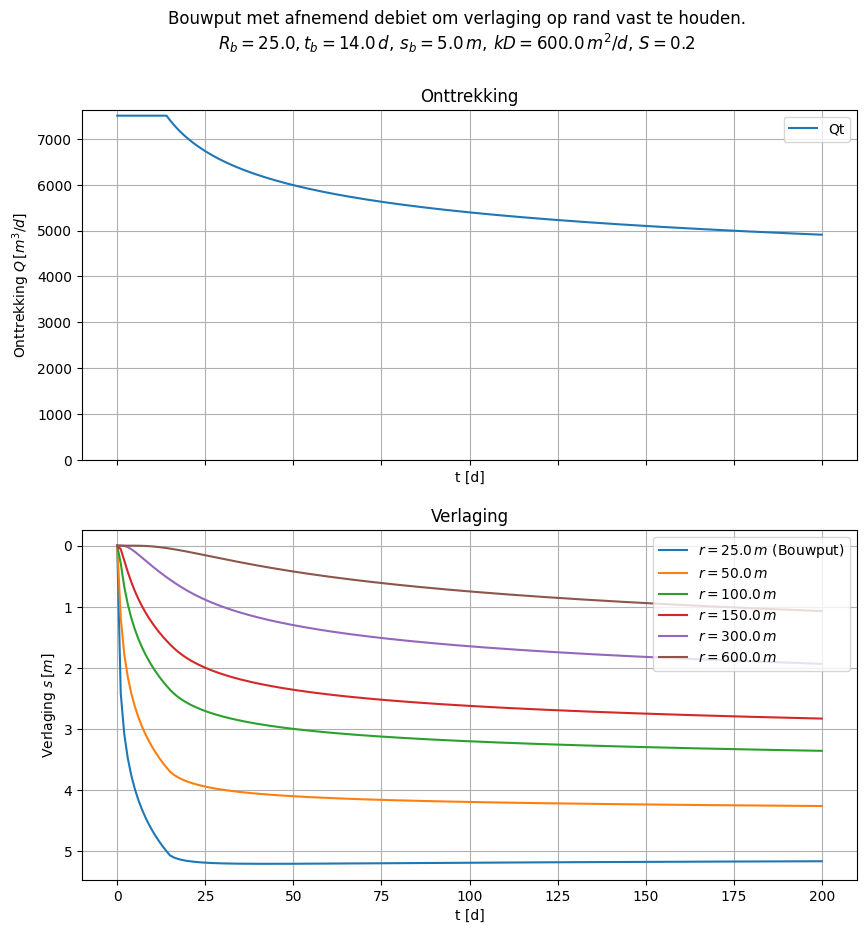

In [ ]:
reload(wf)
kD, S, rb, sb, tb = 600., 0.2, 25., 5., 14.
Rs = [25., 50., 100., 150., 300., 600.]

t = np.arange(201.)

theis       = wf.wTheis(      xw=0., yw=0., aqprops={'kD': kD, 'S': S})
theisSimple = wf.wTheisSimple(xw=0., yw=0., aqprops={'kD': kD, 'S': S})

# Schatting tijdsafhankeijk debiet Qt
dd = theis.dd(x=rb, y=0., t=t, Q=1.) # verlaging door Q=1
Qt = np.zeros_like(dd)
Qt[dd > 0] = sb / dd[dd > 0] # Debiet is sb/dd

# Zet constant debiet in aanloopperiode tb
Qt[t <= tb] = Qt[t <= tb][-1]

title = fr"""Bouwput met afnemend debiet om verlaging op rand vast te houden.
$R_b={rb}, t_b={tb}\,d,\,s_b={sb}\,m,\,kD={kD}\,m^2/d,\,S={S}$"""

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
fig.suptitle(title)

ax1.set(title="Onttrekking", xlabel="t [d]", ylabel=r"Onttrekking $Q\,[m^3/d]$")
ax2.set(title="Verlaging",   xlabel="t [d]", ylabel=r"Verlaging $s\,[m]$")

ax1.plot(t, Qt, label="Qt")

ax1.grid()
ax1.set_ylim(0., ax1.get_ylim()[1])
ax1.legend()

for r in Rs:
    label = fr"$r={r}\,m$"
    if r == rb:
        label = label + " (Bouwput)"
    BrTheis       = theis.BR(      r=r, t=t)
    sTheis        = lfilter(BrTheis,       1., Qt)     
    ax2.plot(t, sTheis, label=label)

ax2.invert_yaxis()
ax2.grid()
ax2.legend(loc='upper right')

fig.savefig(os.path.join(dirs.images, "bouwput_onttr_tijdsafh.png"))

plt.show()

# Lineaire elementen, sleufbemaling

Bij sleufbemaling of peilbeheersing met sloten of grachten (ook drainage) is  niet het debiet maar de verlaging het doel, net zoals dat bij bouwputten het geval is.

## Tijdsafhankelijke verlaging bij sleufbemaling

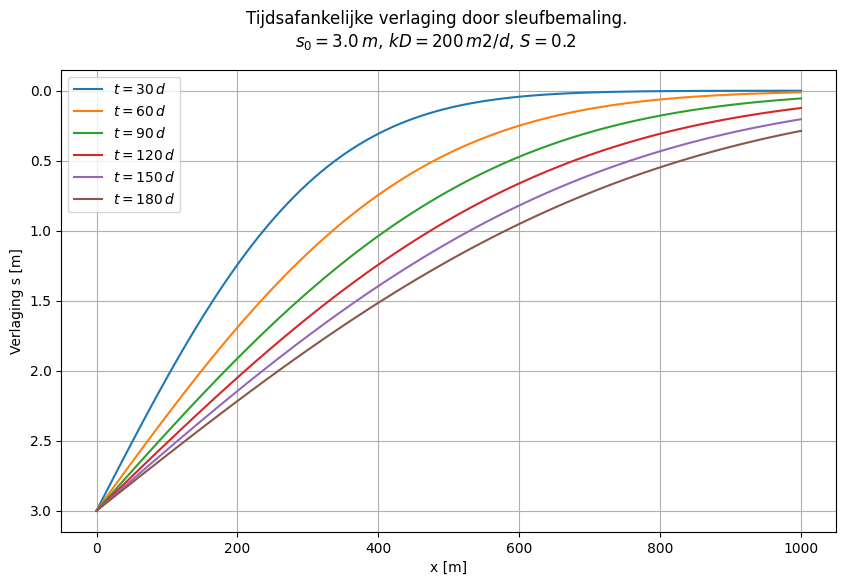

In [796]:
s0 = 3.0
kD, S = 200., 0.2
x = np.linspace(0, 1000., 101)
times = np.arange(1, 7) * 30.

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(fr"""Tijdsafankelijke verlaging door sleufbemaling.
$s_0={s0:.2}\,m,\,kD={kD:.0f}\,m2/d,\,S={S}$""")

ax.set(xlabel='x [m]', ylabel="Verlaging s [m]")

for t in times:
    u = np.sqrt(x ** 2 * S  / (4 * kD * t))
    s = s0 * erfc(u)
    ax.plot(x, s, label=fr"$t={t:.0f}\,d$")

ax.invert_yaxis()
ax.grid()
ax.legend()

fig.savefig(os.path.join(dirs.images, "sleuf_verl_tijdsafhankelijk.png"))

plt.show()

## Permanente verlaging door sleubemaling bij gebruik making van de drainageweerstand $c$

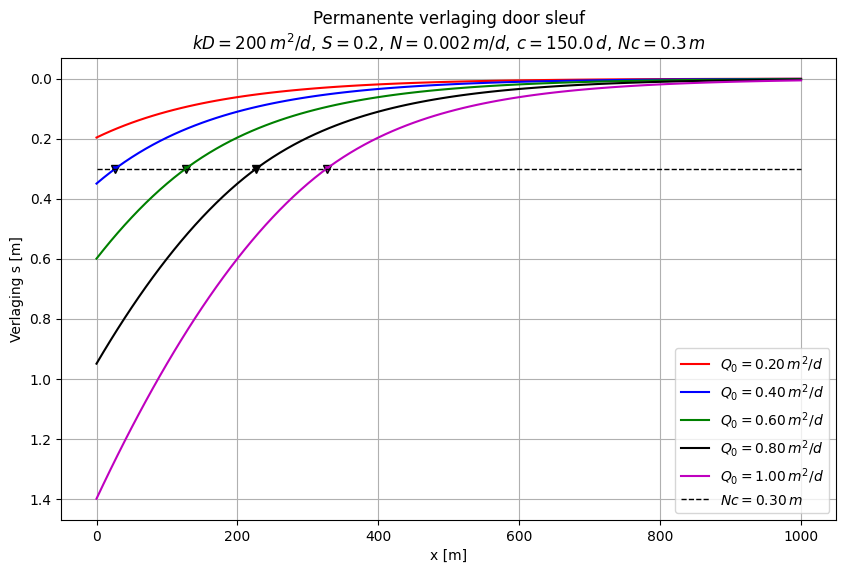

In [745]:
kD, c, N = 200., 150., 0.002
Qs = np.linspace(0, 1., 6)[1:]
lambda_ = np.sqrt(kD * c)
x = np.linspace(0, 1000., 101)

title=fr"""Permanente verlaging door sleuf
$kD={kD:.0f}\,m^2/d,\,S={S},\,N={N}\,m/d,\,c={c}\,d,\,Nc={N * c}\,m$"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='x [m]', ylabel='Verlaging s [m]')
clrs = cycle('rbgkmc')
for Q in Qs:
    clr = next(clrs)

    L = Q / N - lambda_
    if Q == Qs[0]:
        label='Gebiedsovergang'
    else:
        label=""
    if L > 0:
        ax.plot(L, N * c, 'v', mfc=clr, mec='k', label=label)


    s = np.zeros_like(x)
    s[x < L] = N * c + Q / kD * (L - x[x < L]) - N / (2 * kD) * (L ** 2 - x[x < L] ** 2)
    s[x >= L] = N * c * np.exp(-(x[x >=L] - L) / lambda_)
    ax.plot(x, s, clr, label=fr"$Q_0={Q:.2f}\,m^2/d$")


ax.plot(x, np.zeros_like(x) + N * c, 'k--', lw=1, label=fr'$Nc={N * c:.2f}\,m$')

ax.invert_yaxis()
ax.grid()
ax.legend()

fig.savefig(os.path.join(dirs.images, "sleuf_pamanent.png"))

plt.show()

# Drainageweerstand

Bestaande uit drie termen: De weerstand door horizontale stroming, die door contractie van stroomlijnen nabij de sloten en die door verticale stroming tussen watertafel en basis van het freatische pakket. De weerstand van een sliblaag op de bodem van de sloten wordt verwaarloosd bij exfiltratie, dus bij drainage, afvoer van neerslagoverschot. Bij infiltratie moet die wel worden meegenomen.

$$c = \frac{L^2}{12 k_x D} + \frac{L}{\pi \sqrt{k_x k_z}} \ln \left(\frac{D}{\Omega}\sqrt{\frac{k_x}{k_z}}\right) + \frac{D}{2 k_z}$$



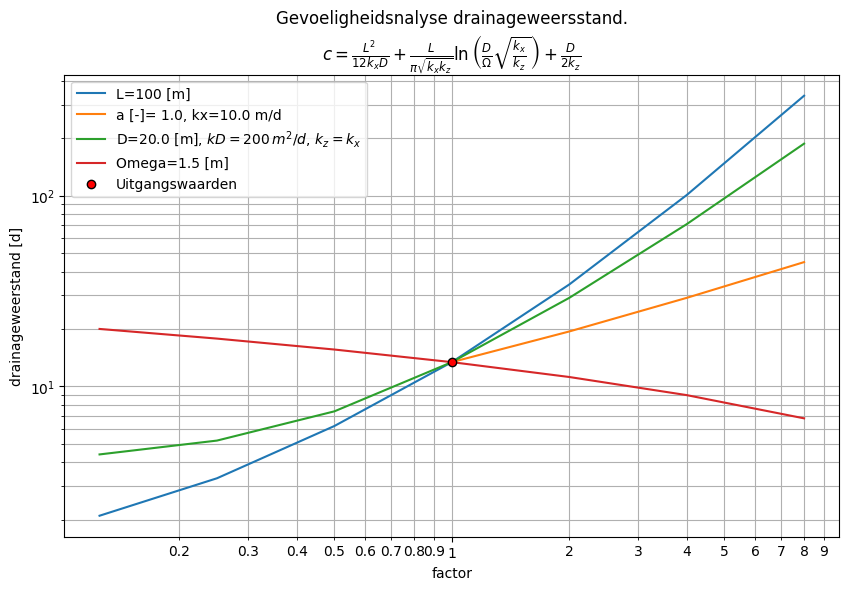

In [789]:
L, kx, a, D, Omega = 100, 10., 1., 20., 1.5

def cdrainage(kx=None, a=None, L=None, D=None, Omega=None):
    kz = kx / a
    k = np.sqrt(kx * kz)
    c = L ** 2 / (12 * kx * D) + L / (np.pi * k) * np.log(D / Omega * np.sqrt(kx / kz)) + D / (2 * kz)
    return np.round(c, decimals=1)

title=r"""Gevoeligheidsnalyse drainageweersstand.
$c = \frac{L^2}{12 k_x D} + \frac{L}{\pi \sqrt{k_x k_z}} \ln \left(\frac{D}{\Omega}\sqrt{\frac{k_x}{k_z}}\right) + \frac{D}{2 k_z}$"""


fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='factor', ylabel='drainageweerstand [d]', xscale='log', yscale='log')

vars = {'L': L, 'a': 1., 'D': D, 'Omega': Omega}
kw = {'L': L, 'kx': kx, 'a': a, 'D': D, 'Omega': Omega}
facs = np.array([0.125, 0.25, 0.5, 1.0, 2., 4., 8.])
kD = kw['kx'] * kw['D']
for pname, value in vars.items():
    kwargs = kw.copy()
    kwargs[pname] = facs * kw[pname]
    label=f"{pname}={kw[pname]} [m]"
    
    # keep kD constant
    if pname == 'D':
        kwargs['kx'] = kD / kwargs['D']
        kwargs['a'] = 1
        label = label + fr", $kD={kD:.0f}\,m^2/d,\,k_z=k_x$"                  

    if pname == 'a':
        kwargs[pname] = kw[pname] * facs[facs >= 1]        
        cdr = cdrainage(**kwargs)        
        ax.plot(facs[facs >= 1], cdr, label=f"{pname} [-]= {kw[pname]}, kx={kx} m/d")
        continue
            
    cdr = cdrainage(**kwargs)
    ax.plot(facs, cdr, label=label)
ax.plot(1, cdrainage(**kw), 'ro', mec='k', label="Uitgangswaarden")
ax.grid(which='both')

# ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1g'))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1g'))
ax.legend()

fig.savefig(os.path.join(dirs.images, "drainageweerstand.png"))

plt.show()
